
<div class="alert alert-block alert-warning">
Disclaimer: Reference herein to any specific commercial
product, process, or service by trade name,
trademark, manufacturer, or otherwise, does
not constitute or imply its endorsement by the
United States Government or the Jet
Propulsion Laboratory, California Institute of
Technology.  
</div>

# Run MITgcm on Amazon Web Service cloud

> Jinbo Wang <Jinbo.Wang@jpl.nasa.gov>

>PO.DAAC, Jet Propulsion Laboratory, California Institution of Technology

>July 28, 2022


***
## Objectives
 - Demonstrate using Fortran in the cloud (AWS EC2)

***
## Steps
 1. Start an AWS cloud computer (Elastic Computer Cloud, EC2) 
 1. Configure the EC2 with the necessary software
 1. Demo a simple hello_world.f90 code
 1. Running MITgcm
 
Please refer to [this notebook](https://github.com/podaac/the-coding-club/blob/main/notebooks/Earthdata_webinar_20220727.ipynb) if you do not have an AWS account. 

## Step 1 - Start an EC2


- Log in through aws console https://aws.amazon.com/console/
 - Start an EC2 (AWS jargon: launch an instance, layman's interpretation: start a remote server hosted by AWS)
   - Name and Tags: run_mitgcm
   - Application and OS Images (Amazon Machine Image): 
   >**Red Hat Enterprise Linux 8 (HVM) SSD Volume type (free-tier elegible)**
   - Instance type: t2.micro (1CPU, 1Gb memory) (If you have a institution- or project-supported AWS account, try to use a bigger computer with >4G memory.)
   - Key pair (login): "Create new key pair" (or choose an existing key pair if this is not the first time)
     - enter a name, e.g., "aws_ec2"  -> create key pair 
     - look for the .pem file in the Download folder, move it to .ssh folder. 
     > ```mv ~/Downloads/aws_ec2.pem .ssh/```
     - change permission to 400 using 
     > ```chmod 400 aws_ec2.pem```
   - check the two boxes for HTTP and HTTPS for the webserver
   - Add storage: 10 Gb should be fine for prototyping and testing. You have total 30Gb free storage, which can be split among three EC2s for example. 
   - Click "Launch Instance" button

 
#### Reference
 - AWS get set up for amazon EC2: https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/get-set-up-for-amazon-ec2.html
 - AWS Get started with AWS EC2: https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/EC2_GetStarted.html
***


## Step 2 - Login and install the necessary software

1. Find the public IP from your EC2 dashboard. (The EC2 dashboard example: [link](https://catalog.us-east-1.prod.workshops.aws/workshops/21c996a7-8ec9-42a5-9fd6-00949d151bc2/en-US/pre/intro-ec2))

1. First connect to the instance via ssh. 
```shell
     ssh -i "~/.ssh/aws_ec2.pem" ec2-user@The_public_ip_address -L 9889:localhost:9889
```
> 
     Remember to set the following parameters appropriately:
     * `-i` points the ssh client on your local machine at your pem key to authenticate
     * `-L` tunnels traffic on port `9889` between the ec2 instance and your local machine. This port number can be any value between 1024 and 32767.
1. Update packages. Optionally install wget, git etc. for downloading this notebook from github.com
     > ```sudo yum update -y && sudo yum install git vim -y```
1. Install gfortran
     > ```sudo yum install gcc gcc-gfortran```
***
### Advanced approach using "User data" box to install softwares while launching the EC2 (replacing step 3.3)

The following replaces step 2.3 and 2.4, but is not required in this tutorial. 

The system software updates can be done by inserting the following bash script into the "User data" box during the Launch Instance step (Step 2). It replaces Steps 3.3. 
```shell
#!/bin/bash
  sudo yum update -y
  sudo yum install vim git -y
  sudo yum install gcc gcc-gfortran -y
```
***


## Step 3 - Test hello_world.f90

Save the following into hello_fortran.f90 (using vim):
```fortran
program hello
  print *, 'Hello, World!'
end program hello
```

Compile hello_world.f90 from the terminal:

```bash
gfortran hello_world.f90 -o hello_world.exe
```

Run the code:

```bash
./hello_world.exe
```

You should be able to see the output on the screen
> Hello, World!

## Clone MITgcm into the EC2

MITgcm's source code is hosted on github https://github.com/MITgcm/MITgcm. 

Run the following code to clone the source code into the EC2 into the folder ```~/MITgcm```:

```bash
cd ~/
mkdir MITgcm
cd MITgcm
git clone git@github.com:MITgcm/MITgcm.git
```

Run one of the simplest verification code ```tutorial_barotropic_gyre``` in the verification folder ```/MITgcm/MITgcm/verification```.

```bash
cd ~/MITgcm/MITgcm/verification/tutorial_barotropic_gyre/input
```

Open the ```data``` file and change the length of the run by chaning the following lines:

>Change Line 25 to: ```nTimeSteps=25920``` #with dt=1200 seconds, 25920 steps produce a one year simulation.

>Change Line 29 to: ```dumpFreq=2592000``` #Save output every 30 days

You can find the instruction on compile and run the code from the included README.md file. Run the following code to compile and run the MITgcm verification:

Configure and compile the code:
```bash
  cd ~/MITgcm/MITgcm/verification/tutorial_barotropic_gyre/build
  ../../../tools/genmake2 -mods ../code
  make depend
  make
  cd ..
```

If you use an instance with multiple CPUs, use ```make -j nn``` where nn is the number of CPUs to speed up the compilation. 

To run:
```bash
  cd run
  ln -s ../input/* .
  ln -s ../build/mitgcmuv .
  ./mitgcmuv > output.txt
  cd ..
```

If everything goes OK, you should be able to see the model output within the ```input``` folder within several minutes (it is a barotropic small model setup). The following is a subset of the outputs. 

>```
bathy.bin                    PH.0000000100.001.001.data   PHL.0000002100.001.001.data  S.0000003000.001.001.data  T.0000004800.001.001.meta  U.0000006700.001.001.meta  V.0000008600.001.001.meta
data                         PH.0000000100.001.001.meta   PHL.0000002100.001.001.meta  S.0000003000.001.001.meta  T.0000004900.001.001.data  U.0000006800.001.001.data  V.0000008700.001.001.data
data.pkg                     PH.0000000200.001.001.data   PHL.0000002200.001.001.data  S.0000003100.001.001.data  T.0000004900.001.001.meta  U.0000006800.001.001.meta  V.0000008700.001.001.meta
Depth.001.001.data           PH.0000000200.001.001.meta   PHL.0000002200.001.001.meta  S.0000003100.001.001.meta  T.0000005000.001.001.data  U.0000006900.001.001.data  V.0000008800.001.001.data
Depth.001.001.meta           PH.0000000300.001.001.data   PHL.0000002300.001.001.data  S.0000003200.001.001.data  T.0000005000.001.001.meta  U.0000006900.001.001.meta  V.0000008800.001.001.meta
DRC.data                     PH.0000000300.001.001.meta   PHL.0000002300.001.001.meta  
```

## Read the model output

The model is set up on 62 by 62 grids. The MITgcm binary output is 'big-endian 32bit' by default. Use ```'f>f4'``` to read the output using ```numpy.fromfile```.  

```python
import numpy as np

pth='~/MITgcm/MITgcm/verification/tutorial_barotropic_gyre/run/'

d=np.fromfile(pth+'T.0000010000.001.001.data','>f4').reshape(62,62) 
print(d)
```

```
[[ 0.          0.          0.         ...  0.          0.         0.        ]
 [ 0.         -0.01527151 -0.01525651 ... -0.01780485 -0.01785214 0.        ]
 [ 0.         -0.01519887 -0.01497208 ... -0.01778286 -0.01784351 0.        ]
 ...
 [ 0.         -0.01973504 -0.01894732 ... -0.01741584 -0.01739461 0.        ]
 [ 0.         -0.01989223 -0.01967057 ... -0.01743554 -0.01740155 0.        ]
 [ 0.          0.          0.         ...  0.          0.         0.        ]]
```

## Reader's excercise

- How to visualize the results? The reader can refer to [our previous tutorial](https://github.com/podaac/the-coding-club/blob/main/notebooks/Earthdata_webinar_20220727.ipynb) to set up a jupyterlab for post-simulation analyses. 

The following is a snapshot of a jupyterlab interface for analyzing the model output. 

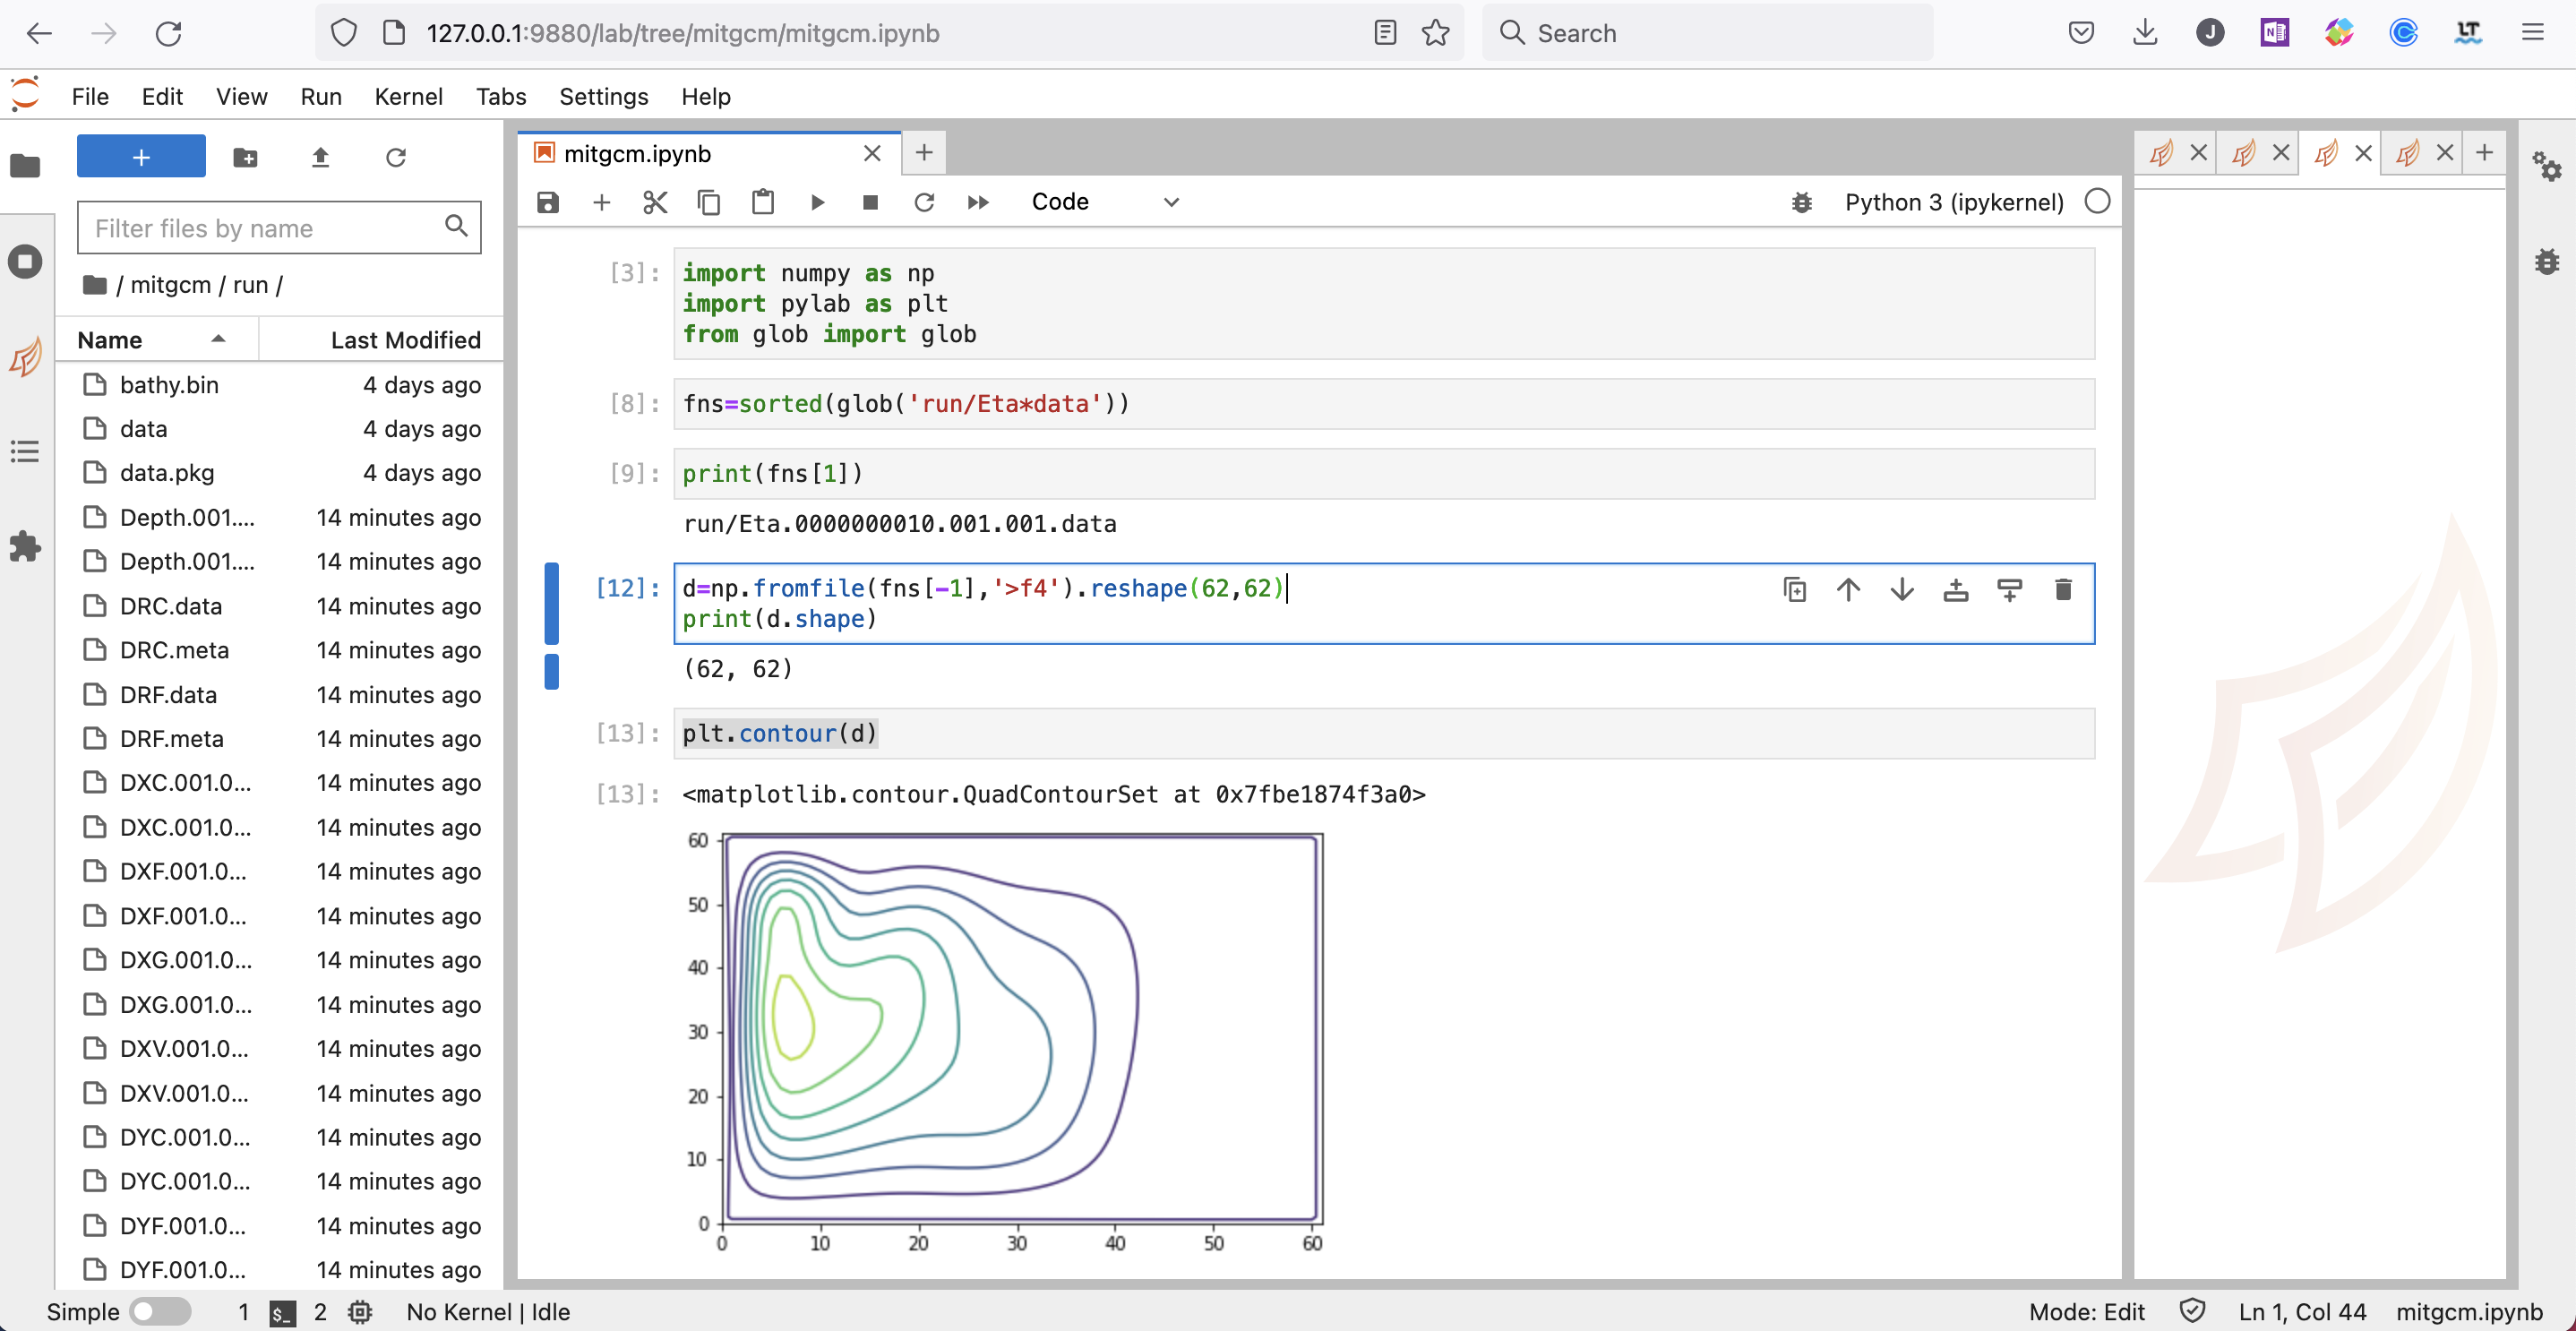